<a href="https://colab.research.google.com/github/vishnuvenu94/bert_sarcasm_detection/blob/master/bert_sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
import json
token = {'username':'enter-username','key':'enter-key'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection -p /content

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 108MB/s]


In [9]:
!unzip \*.zip


Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


# Data


In [10]:
import pandas as pd
df = pd.read_json('./Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()
# print(df["headline"][4])




,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [11]:
df.shape

(28619, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


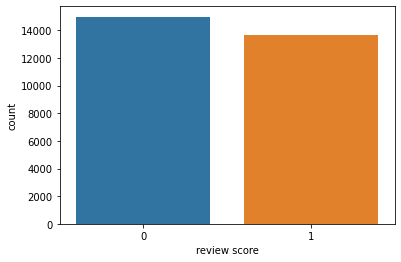

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df.is_sarcastic)
plt.xlabel('review score');

In [0]:
!pip install -qq transformers

In [0]:
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from collections import defaultdict
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [0]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
token_lens = []

for txt in df.headline:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

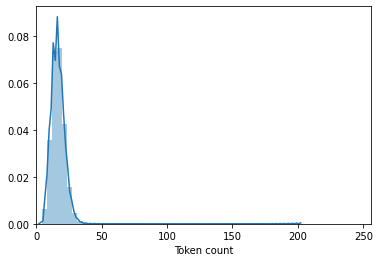

In [19]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 50

In [0]:
class SarcasmDataset(Dataset):
  def __init__(self,comments, targets, tokenizer, max_len):

    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):

    return len(self.comments)
  
  def __getitem__(self, item):

    comment = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
      )

    return {
        'comment_text': comment,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
      }


In [0]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.4,stratify= df.is_sarcastic.values)
df_val, df_test = train_test_split(df_test, test_size=0.5,stratify= df_test.is_sarcastic.values)

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SarcasmDataset(
    comments=df.headline.to_numpy(),
    targets=df.is_sarcastic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [26]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


In [0]:
device = torch.device("cuda")

# Model


In [0]:
class SarcasmClassifier(nn.Module):

  def __init__(self):
    super(SarcasmClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 1)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [29]:
model = SarcasmClassifier()
model.to(device)

SarcasmClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [0]:
EPOCHS = 10

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

optimizer = AdamW(optimizer_parameters, lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)



# Training

In [0]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)).to(device)


In [0]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    fin_targets = []
    fin_outputs = []
    losses = []

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        input_ids = d["input_ids"]
        
        attention_mask = d["attention_mask"]
        targets = d["targets"]

        input_ids = input_ids.to(device, dtype=torch.long)

        attention_mask = attention_mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,

        )

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    targets=fin_targets
    accuracy = metrics.accuracy_score(targets, outputs)
    
    return accuracy, np.mean(losses)


In [0]:
def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses=[]
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            input_ids = d["input_ids"]

            attention_mask = d["attention_mask"]
            targets = d["targets"]

            input_ids = input_ids.to(device, dtype=torch.long)

            attention_mask = attention_mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,

            )
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    outputs = np.array(fin_outputs) >= 0.5
    targets=fin_targets
    accuracy = metrics.accuracy_score(targets, outputs)
    return accuracy, np.mean(losses)

In [34]:

history = defaultdict(list)


best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_accuracy,train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler)
  val_accuracy, val_loss= eval_fn(val_data_loader, model, device)
  print(f"\n Train accuracy Score = {train_accuracy}")
  print(f"\n Validation accuracy Score = {val_accuracy}")
  history['train_accuracy'].append(train_accuracy)
  history['train_loss'].append(train_loss)
  history['val_accuracy'].append(val_accuracy)
  history['val_loss'].append(val_loss)
  if val_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_accuracy



        


Epoch 1/10
----------


  0%|          | 0/1074 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
100%|██████████| 358/358 [00:11<00:00, 32.07it/s]



 Train accuracy Score = 0.8683245006114961

 Validation accuracy Score = 0.9150943396226415
Epoch 2/10
----------


100%|██████████| 358/358 [00:11<00:00, 31.66it/s]



 Train accuracy Score = 0.9594083046997846

 Validation accuracy Score = 0.9173654786862334
Epoch 3/10
----------


100%|██████████| 358/358 [00:11<00:00, 32.37it/s]



 Train accuracy Score = 0.9843922893250248

 Validation accuracy Score = 0.9208595387840671
Epoch 4/10
----------


100%|██████████| 358/358 [00:11<00:00, 31.93it/s]



 Train accuracy Score = 0.9928949973793023

 Validation accuracy Score = 0.9217330538085255
Epoch 5/10
----------


100%|██████████| 358/358 [00:11<00:00, 32.25it/s]


 Train accuracy Score = 0.9948750800768738

 Validation accuracy Score = 0.9210342417889588
Epoch 6/10
----------



100%|██████████| 358/358 [00:11<00:00, 32.16it/s]



 Train accuracy Score = 0.9972628268592394

 Validation accuracy Score = 0.9233053808525507
Epoch 7/10
----------


100%|██████████| 358/358 [00:11<00:00, 31.87it/s]


 Train accuracy Score = 0.9989517209248151

 Validation accuracy Score = 0.9212089447938504
Epoch 8/10
----------



100%|██████████| 358/358 [00:11<00:00, 31.99it/s]


 Train accuracy Score = 0.9991264341040126

 Validation accuracy Score = 0.923130677847659
Epoch 9/10
----------



100%|██████████| 358/358 [00:11<00:00, 32.14it/s]


 Train accuracy Score = 0.9993011472832101

 Validation accuracy Score = 0.9224318658280922
Epoch 10/10
----------



100%|██████████| 358/358 [00:11<00:00, 32.11it/s]



 Train accuracy Score = 0.999650573641605

 Validation accuracy Score = 0.9233053808525507


# Inference

In [35]:
test_accuracy, test_loss = eval_fn(
  test_data_loader,
  model,
  device,
 
)

print(test_accuracy)

100%|██████████| 358/358 [00:10<00:00, 32.62it/s]

0.9191125087351503


In [0]:
review_text = "Breathing oxygen linked to staying alive"

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [38]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction=torch.sigmoid(output).cpu().detach().numpy().tolist()
prediction=np.squeeze(prediction) >= 0.5



print(f'Review text: {review_text}')
print(f'Is it sarcastic  : {prediction}')

Review text: Breathing oxygen linked to staying alive
Is it sarcastic  : True


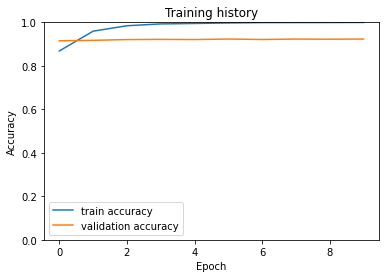

In [39]:
plt.plot(history['train_accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


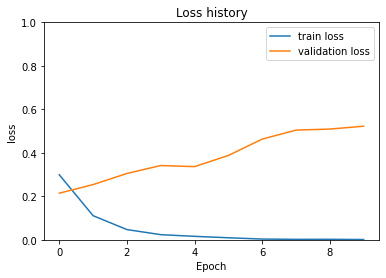

In [40]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  comment_texts = []
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      preds=torch.sigmoid(outputs).cpu().detach().numpy().tolist()
      preds = np.array(preds) >= 0.5

      comment_texts.extend(texts)
      predictions.extend(preds)

      real_values.extend(targets.cpu().detach().numpy().tolist())

      

  predictions = np.stack(predictions)

  real_values = np.stack(real_values)
  return comment_texts, predictions, real_values

In [0]:
y_comment_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

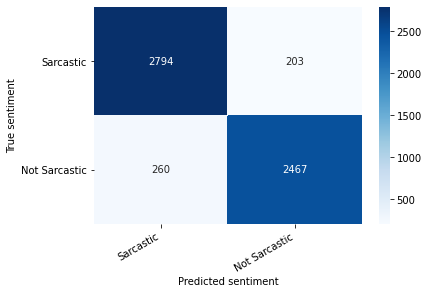

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=["Sarcastic","Not Sarcastic"], columns=["Sarcastic","Not Sarcastic"])
show_confusion_matrix(df_cm)

In [44]:
print(classification_report(y_test, y_pred, target_names=["Sarcastic","Not Sarcastic"]))

               precision    recall  f1-score   support

    Sarcastic       0.91      0.93      0.92      2997
Not Sarcastic       0.92      0.90      0.91      2727

     accuracy                           0.92      5724
    macro avg       0.92      0.92      0.92      5724
 weighted avg       0.92      0.92      0.92      5724



In [45]:
idx = 11

comment_text = y_comment_texts[idx]
true_value = y_test[idx]
pred_value = y_pred[idx]

print(comment_text)
print(f"Ground truth: {true_value>0}")
print(f"Prediction : {np.squeeze(pred_value)}")



this hotel a goddamn maze, reports father
Ground truth: True
Prediction : True
